# Hands-On ML: Chapter 7, Ensemble Learning and Random Forests

This chapter is based on the idea of *the wisdom of the crowd*-- that for complex problems, aggregating the answers of many people often yields better results than answers from a few experts. Likewise, we can aggregate the predictions from a group of predictors (classifiers/regressors). This aggregate is called an `ensemble`, the technique is called `ensemble learning` and the algorithms to construst and train these models is called `ensemble method`. Typically, we do this an the **end of a project**. We first develop a few good models (like the ones in previous chapters) then use an ensemble method to aggregate them. We will discuss bagging, boosting, stacking and more + random forest.

Summary

1. Introduction
2. Bagging & Pasting, Out-of-Bag evaluation
3. Random Forest
4. AdaBoost
5. Gradient Boosting
6. Stacking

In [51]:
import warnings
warnings.filterwarnings("ignore")

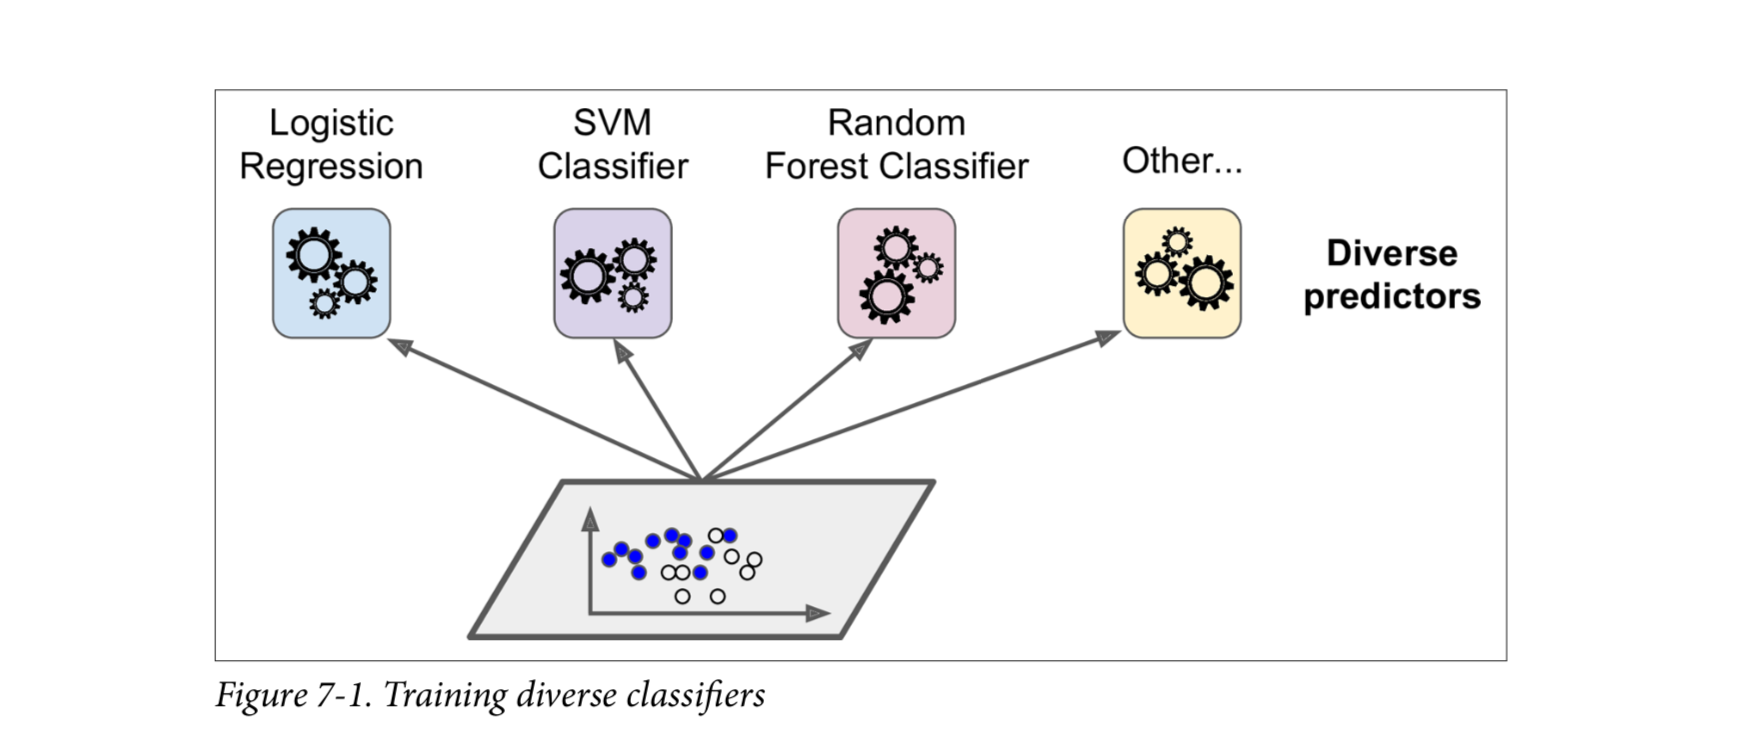

In [2]:
#Basic Voting Ensemble
from IPython.display import Image
Image(filename = './images/basic_ensemble_1.png')

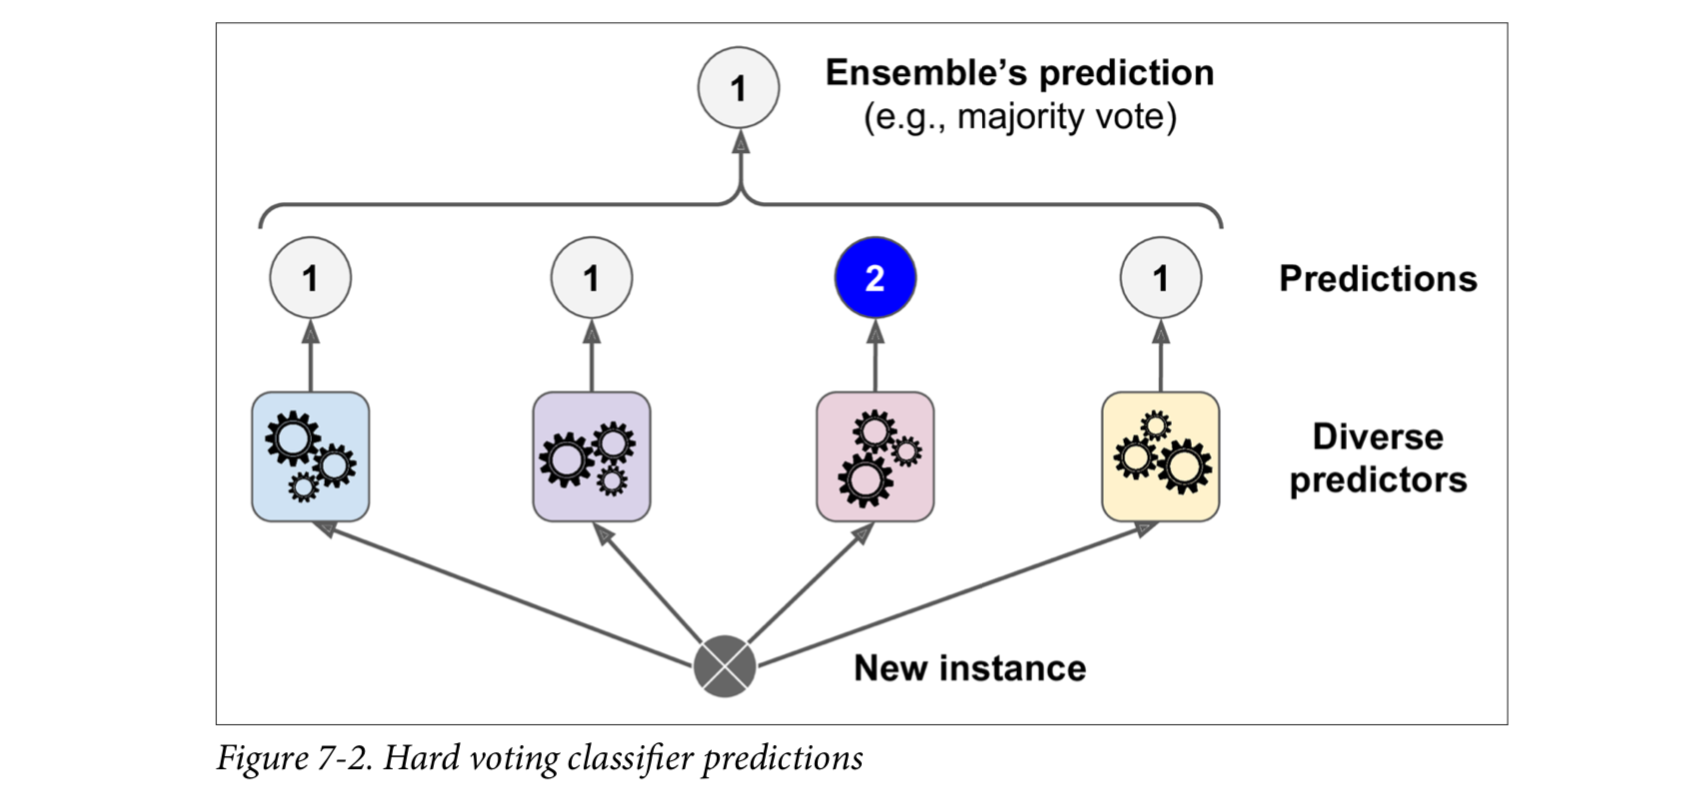

In [4]:
Image(filename = './images/basic_ensemble_2.png')

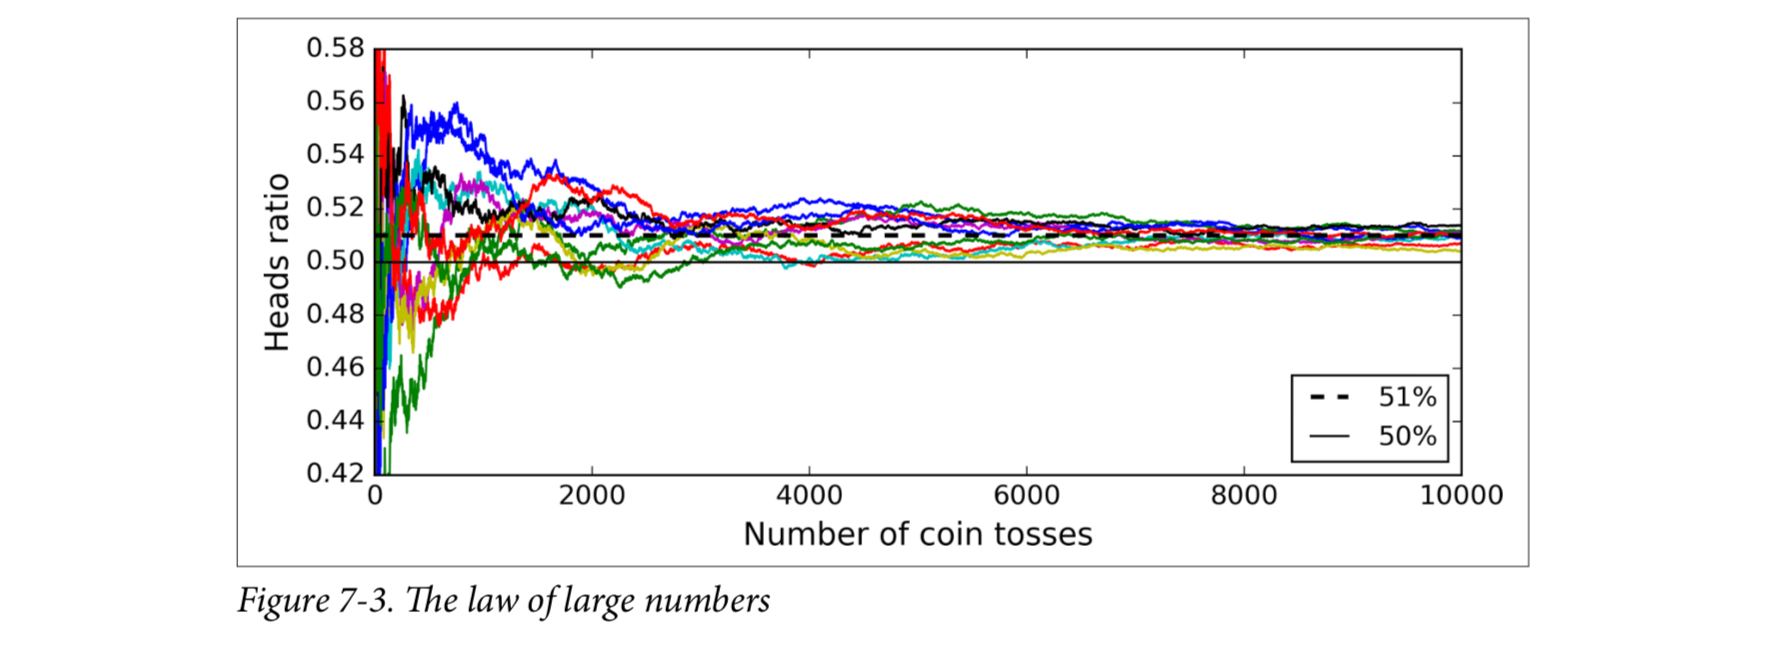

In [5]:
Image(filename = './images/law_of_large_numbers.png')

### Basic Voting Ensemble

Say through the modelling process, we came up with 4 fairly good classifiers as shown above. While we can decide on one of them, we can also aggregate their predictions with a voting process. The most basic voting system is **majority vote**, which class gets the most votes win. E.g. if 3 of the models predict class A, then we will predict class A. Empirical studies show that this works surprisingly well, even with weak learners (individual learners that are underfitted and perform slightly better than random).

**The question is why?** It is the `law of large numbers`. Suppose we have a slightly biased coin that has true percentage of 49% tail & 51% head. What is the probability heads will be the majority after X number of trials? Turns out, for 1,000 trials, this probability reaches 75%. At 10,000 trials, it climbs to 97%. Ensemble learning is the same, if we have a large number of predictors, the majority prediction may be quite good. However, this assumes perfectly independent, uncorrelated errors.

In [144]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np

data, labels = make_moons(n_samples=10000, noise=0.4)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 42)

In [59]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'hard' #we predict majority class. If the learners have predict_proba() method, 
    #you can use soft and aggregate the probabilities instead
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFo...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [60]:
#The ensemble outperforms logistic regression and random forest, but not SVC in this case
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train) #now 
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8315
RandomForestClassifier 0.8415
SVC 0.8745
VotingClassifier 0.8665


## Bagging and Pasting

We want to get diversified weak learners-- if the learners are similar, there is not added value in aggregating them. There are generally two ways to get different learners: 1) Specify different training algorithms for the learners and 2) Use different data to train the learners. `Bagging` and `Pasting` belongs to the second group, where we exposed the learners to different subsets of the training data. `Bagging` creates the subsets with replacement for one predictor while `Pasting` creates the subsets without replacement for one predictor. That means the same instance can be used multiple times for the whole ensemble, but in `Pasting`, it cannot be used multiple times for one learner.

`Bagging` generally performs better than `Pasting`, possibly because `Pasting` requires a very large dataset that is often not avaliable.

In [67]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500, #use CART for learners, create 500 learners
    max_samples = 100, bootstrap = True, n_jobs = -1, #n -1 means use all avaliable cores
    oob_score = True #get out-of-bag score for later
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.873

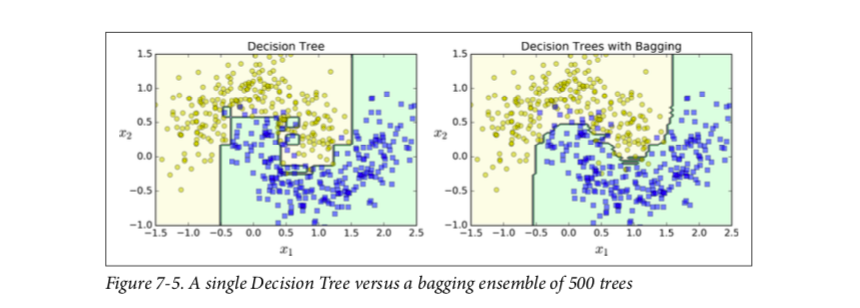

In [65]:
#Ensemble methods allow a much smoother line (still orthogonal though)
#This is because each learner introduces more diveristy to the trees, allowing us to get greater bias
Image(filename = './images/single_tree_vs_bagging.png')

### Out-of-Bag Evaluation

For bagging, some instances may be sampled several times and some instances may never be sampled. It can be shown that on average, about 63% of the the training data will be sampled for a learner, leaving 37% of the instances out (note, this 63% will very likely be different for each learner in the ensemble). We call this 37% the `out-of-bag` instances.

In a data-poor environment, we want to make use of avaliable data as much as we can. Therefore, we can do an `out-of-bag` evaluation. Evaluate each learner with their `out-of-bag` observations and average out the score.

In [68]:
#We already called the oob_score_ method in the code above
bag_clf.oob_score_

0.859375

In [70]:
#Since our trees have predict_proba(), we can also get the class probabilities
bag_clf.oob_decision_function_

array([[0.07113821, 0.92886179],
       [0.6902834 , 0.3097166 ],
       [0.49795082, 0.50204918],
       ...,
       [0.05633803, 0.94366197],
       [0.07243461, 0.92756539],
       [0.78818737, 0.21181263]])

### Random Patches and Random Subspaces

When dealing with high-dimensional inputs, we can also sample the features to introduce diversity and trade-off higher bias for even lower variance. When we sample **both** training instances and features, this is called `Random Patches` method. When we only sample features but keep on training instances, this is called `Random Subspaces`.

`Random Patches` by setting e.g. (bootstrap = True, max_samples = 0.7, bootstrap_features = True, max_features = 0.7)

`Random Subspaces` by setting e.g. (bootstrap = False, max_samples = 1, bootstrap_features = True, max_features = 0.7)

### Random Forests

Building a random forest is essentially the same as what we did above-- passing decision tree learners into a bagging classifier. But instead, we can use `RandomForestClassifier` which is better optimized and more convenient.

The random forest algorithm will introduce extra randomness when growing tress. Instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features (Random Patches). 

In [73]:
#Using random forest classifier
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.867

In [72]:
#Rough equivalence in terms of hyperparameters
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter = 'random', max_leaf_nodes = 16),
    n_estimators = 500, max_samples = 1.0, bootstrap = True, n_jobs = -1
)

### Extremely Randomnized Trees Ensemble

If we want to trade-off for even higher bias and lower variance, we can make the trees even more random. Instead of searching for the best thresholds/rules for the randomly sampled features, we can randomnized the rules as well. This will make training faster as well since searching for the best rule is the slowest part of training a tree. It is difficult to tell beforehand whether this method will outperform the original random forest.

In [75]:
from sklearn.ensemble import ExtraTreesClassifier
extra_rnd_clf = ExtraTreesClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1)
extra_rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.867

### Feature Importance

For a single decision tree, important features will appear more often at the root of the tree while less important features will appear near the leafs. Hence, we can average out the depth of each feature across the trees, and use that as an approximation of feature importance. This is **not** a replacement for statistical significance by any means, we cannot perform inference with this. But it does inform us about our features and perhaps allow us to better engineer features to improve the model.

In [76]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.08829812365770022
sepal width (cm) 0.02193165602718816
petal length (cm) 0.43859784273831065
petal width (cm) 0.4511723775768011


## Boosting

`Boosting` (also called hypothesis boosting) refers to any Ensemble method that combine several weak learners into a strong learner. The general idea of most boosting methods is train learners **sequentially** and train on the output/residuals of the predecessor. The two most popular are `AdaBoost` and `Gradient Boosting`. 

----------------

### AdaBoost

AdaBoost works by placing weights on each training instance, and sequentially changing the weights to shift the importance of each data point. The idea is that every successor will pay more attention to the data points that were underfitted by its predecessor.

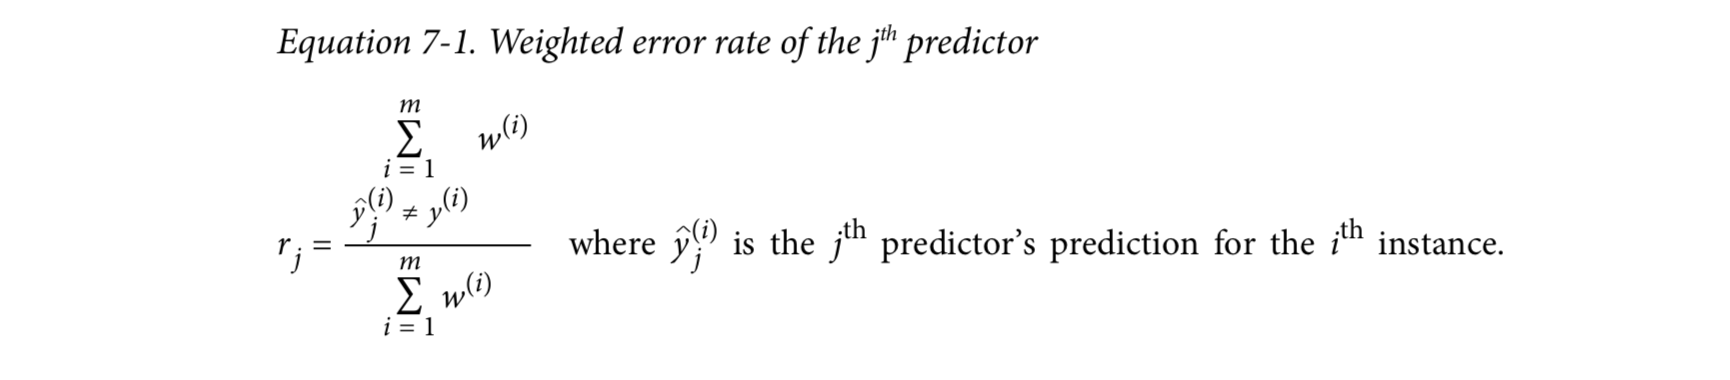

In [80]:
Image(filename = './images/adaboost_error_rate.png')

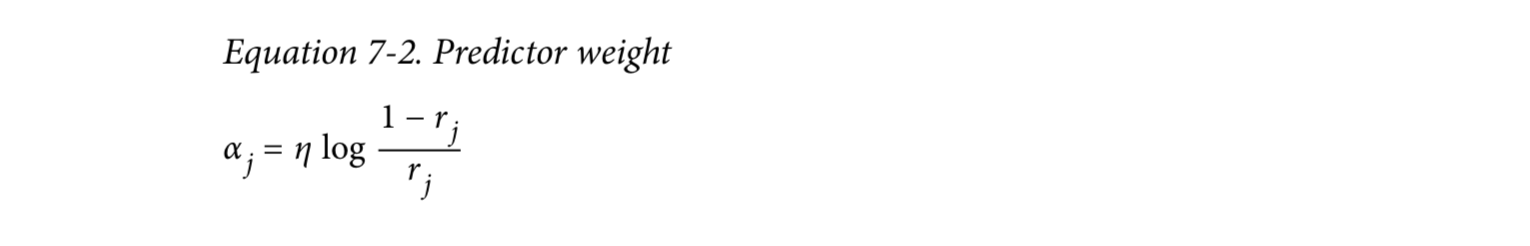

In [83]:
Image(filename = './images/adaboost_predictor_weight.png')

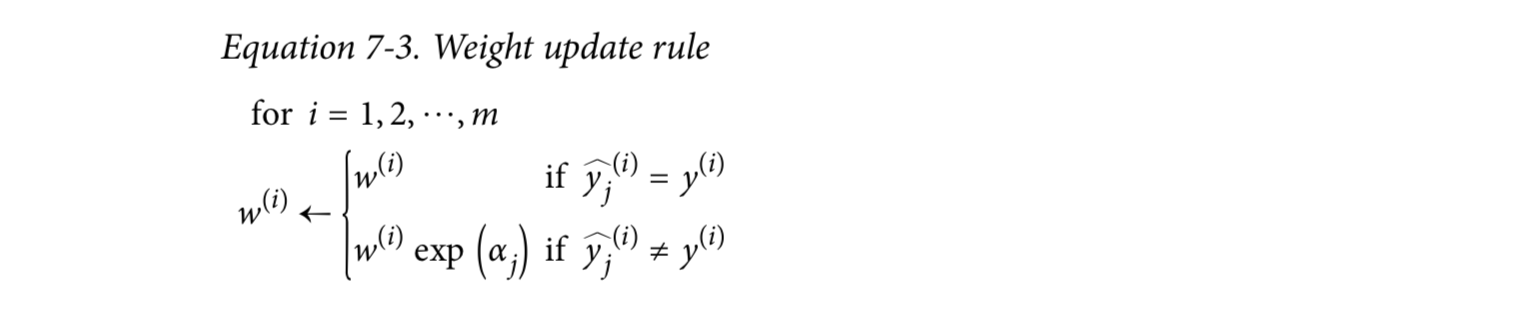

In [81]:
Image(filename = './images/adaboost_update.png')

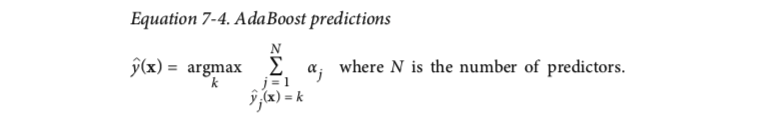

In [85]:
Image(filename = './images/adaboost_predictions.png')

The weighting scheme is fairly simple. There are 3 components 1) `Weighted Error of the Learner` 2) `Weight on the Learner` and 3) `Weight update rule`.

The numerator is the sum of instance weights where the prediction is wrong divided by total weight. This gives us the weighted error of the learner. 

Then we express the new weight on the learner as n * log(1-r/r). The inside is just the ratio of correct rate (1-r) and error rate. Essentially, high error rates result in a low ratio. When the ratio is below 1, log will assign a negative weight to this learner. N is simply the learning rate.

Finally, **mislassified instances are boosted**. If the prediction is correct, we keep the same weight. If the prediction is wrong, we boost it by current weight x exp(new weight).

Then all instances are normalized so it sums to 1.

For predictions, its quite simply. Each learner now has a weight + predicted class. The weight is essentially their vote, and the class which had the largest vote will win.

In [87]:
from sklearn.ensemble import AdaBoostClassifier

#SAMME.R stands for Stagewise Additive Modelling using a Multiclass Expontential loss function
#When there are only 2 classes, SAMME is the same as AdaBoost. It is different when there are multi-classes though
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1), n_estimators = 200,
    algorithm = 'SAMME.R', learning_rate = 0.5
)

ada_clf.fit(X_train, y_train)

y_pred_rf = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.861

### Gradient Boosting

`Gradient Boosting` is similar to AdaBoost in the sense that we are trying to sequentially train learners that focus on the flaws of its predecessor. But instead of tweaking the weight on misclassified instances, gradient boosting will fit the learner on the residuals (y - yhat) of the previous learner. It can be shown that gradient boosting resembles the gradient descent algorithm.

In [149]:
#Nothing special here, this the closed form normal equation to solve for B vector
#Lets generate some linear looking data to play around
X = 2 * np.random.rand(5000, 1)
y = 4 + 3 * X + np.random.randn(5000, 1)
y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [150]:
from sklearn.tree import DecisionTreeRegressor

#Fit the first tree
tree_reg1 = DecisionTreeRegressor(max_depth = 2)
tree_reg1.fit(X_train, y_train)

#Fit second tree on the residuals of the first
y2 = y_train - tree_reg1.predict(X_train)
tree_reg2 = DecisionTreeRegressor(max_depth = 2)
tree_reg2.fit(X_train, y2)

#Fit a third tree on the residuals of the second
y3 = y2 - tree_reg2.predict(X_train)
tree_reg3 = DecisionTreeRegressor(max_depth = 2)
tree_reg3.fit(X_train, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [154]:
#This part is pretty cool, our probability prediction is simply the sum of the learners predicted probabilities
from sklearn.metrics import mean_squared_error
y_pred = sum(tree.predict(X_test) for tree in (tree_reg1, tree_reg2, tree_reg3))

mean_squared_error(y_test, y_pred)

1.1911175972066572

In [155]:
#Use sklearn package instead
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 3, learning_rate = 1.0)
gbrt.fit(X_train, y_train)

y_pred = gbrt.predict(X_test)
mean_squared_error(y_test, y_pred)

1.191117597206657

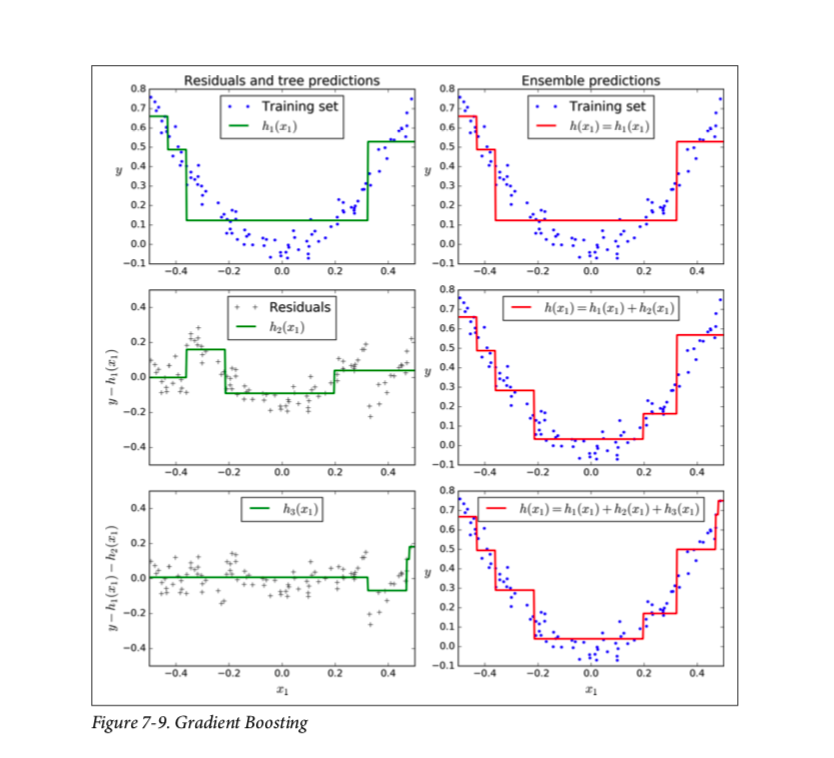

In [156]:
Image(filename = './images/gbrt_graphs.png')

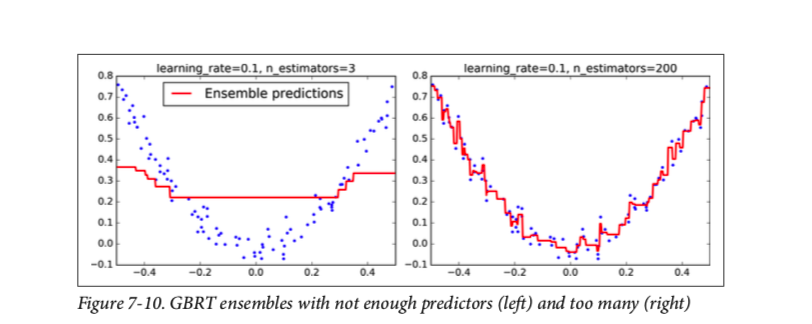

In [158]:
Image(filename = './images/gbrt_shrinkage.png')

### Regularization (Shrinkage)

As you can see, with each additional learner/tree, we can fit the data closer by fitting on the residuals.The `learning_rate` parameter will affect how much each learner will contribute to the total model. If we use a low learning_rate such as 0.1, we will need more learners to fit the data-- trading lower bias with higher variance (and possibly better generalization). We can put this regularization into effect by introducing an early stopper.

In [167]:
#Early stop
gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 120) #Initiate model
gbrt.fit(X_train, y_train) #fit on data

#staged_predict will iterate stage by stage: e.g. 1 learner, 2 learner, ..., n learners
errors = [mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test)] #evaluate test error each stage
bst_n_estimators = np.argmin(errors) #find the index number with lowest error, that'll be the number of learners

gbrt_best = GradientBoostingRegressor(max_depth = 2, n_estimators = bst_n_estimators) #fit that model
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=46, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [182]:
bst_n_estimators

46

In [180]:
#Early stop without having the train all 120 stages
#This implementation will not search for the actual minimum though
#We'll have to add another section to store the errors and do np.argmin again
gbrt = GradientBoostingRegressor(max_depth = 2, warm_start = True)

min_val_error = float('inf')
error_going_up = 0
errors = []
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators #set the number of learners
    gbrt.fit(X_train, y_train) #fit model
    y_pred = gbrt.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred) #test error
    errors.append(val_error)
    if val_error < min_val_error: #if test error fell
        min_val_error = val_error #this is our new best
        error_going_up = 0
    else:
        error_going_up += 1 #error went up, add one to error_going_up
        if error_going_up == 5: #after 5 times of increasing test error, we're gonna stop
            break #early stopping
            
n_estimator = np.argmin(errors)
n_estimator

46

We can also do `Stochastic Gradient Boosting` using `subsample` hyperparameter. Subsample will specify the fraction of training instances to be used for training each tree. This is very similar to bagging. E.g. subsample = 0.25 means each learner will see a random sample of 25% of the total training instances. This can 1) speed up training and 2) you can trade higher bias for lower variance.

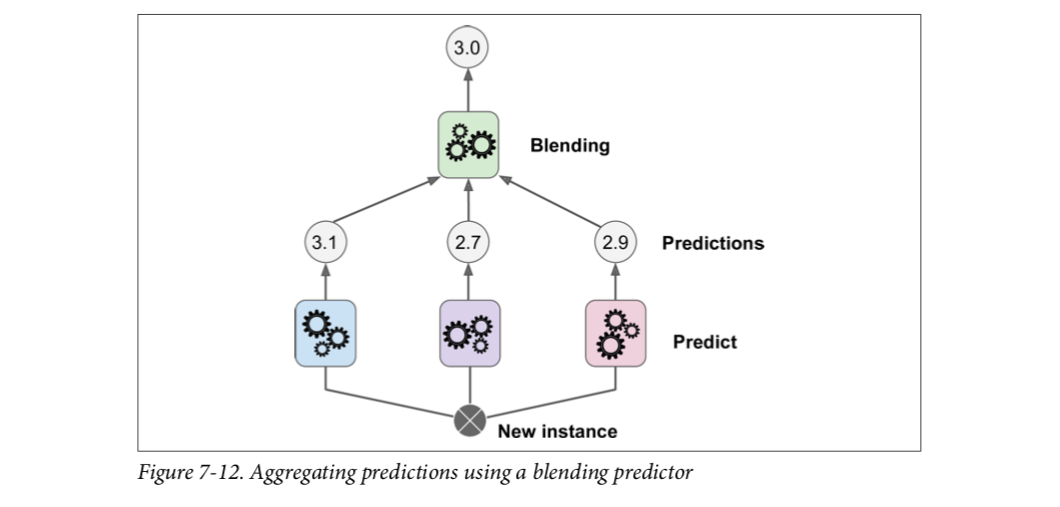

In [183]:
Image(filename = './images/stacking_diagram.png')

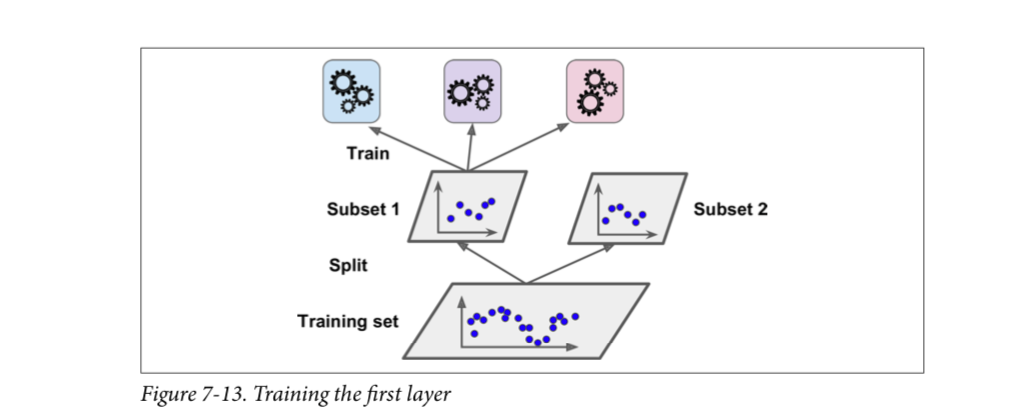

In [185]:
Image(filename = './images/stacking_training.png')

### Stacking

The last ensemble we will discuss is `stacking` or `stacked generalization`. The idea is simple, instead of aggregating with trivial functions like hard voting, why don't we *train* a model to perform this aggregation. The bottom level is the same as always, 3 different learners with different outputs. Then we add a new learner called a `blender` or `meta learner` that takes the predictions as an input and learns the rules to perform a final prediction.

We typically train a blender with a hold-out set. 

1. Split the training data into subset one & subset two 
2. Train the bottom learners with subset one 
3. Predict with subset two (which the bottom learners did not see)
4. Train blender with output of predictions in 3 and labels of subset two

We actually add more blender layers. But we need more data to split (e.g. 2 blender layers will require three subsets).